In [1]:
import glob
import imageio
import os
import PIL
import time
import math

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2
import scipy

import sklearn
from sklearn.model_selection import train_test_split

from IPython import display
from skimage import color

import keras
from keras import callbacks
from keras import optimizers
# from keras.layers import Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers 
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
import tensorflow_addons as tfa
import tensorflow as tf

from google.colab import drive
drive.mount('/content/drive')
from google.colab.patches import cv2_imshow

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# (train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
# train_images = train_images[:,:,:,np.newaxis]
# input_shape = train_images.shape[1:4]

In [2]:
# FOR INITIAL RAW IMAGES
#faulty_dir = '/content/drive/Shareddrives/Senior Thesis/Casting_image/casting_512x512/casting_512x512/def_front/'
#ok_dir = '/content/drive/Shareddrives/Senior Thesis/Casting_image/casting_512x512/casting_512x512/ok_front/'

# FOR AUGMENTED IMAGES
faulty_dir = '/content/drive/Shareddrives/Senior Thesis/Casting_image/casting_data/casting_data/images/def_front/'
ok_dir = '/content/drive/Shareddrives/Senior Thesis/Casting_image/casting_data/casting_data/images/ok_front/'
directories = (faulty_dir, ok_dir)

# check the total number of images we have
faulty = 0
ok = 0
j = -1
for direct in directories:
  j += 1
  print(direct)
  for file in os.listdir(direct):
    # count only number of faulty images
    if j == 0:
      faulty += 1
    if j == 1:
      ok += 1

print(faulty, ok)
# set the values of the X and y arrays
num_images = faulty
input_shape = (4, 4, 1)
height = input_shape[0]
width = input_shape[1]
channels = input_shape[2]

X = np.zeros((num_images,height,width,channels))

# populate the arrays
i = 0
for file in os.listdir(faulty_dir):
  path = (faulty_dir+file)
  im = plt.imread(path)
  scaled_im = cv2.resize(im[:,:,0],(height,width))
  scaled_im = scaled_im[:, :, np.newaxis]
  X[i,:,:,:] = scaled_im
  # 1 for faulty
  i+=1

train_images = X;

/content/drive/Shareddrives/Senior Thesis/Casting_image/casting_data/casting_data/images/def_front/
/content/drive/Shareddrives/Senior Thesis/Casting_image/casting_data/casting_data/images/ok_front/
4184 3157


In [3]:
train_images_scaled = train_images.astype('float32')
train_images_scaled = (train_images_scaled - 127.5) / 127.5  # Normalize the images to [-1, 1]
print(type(train_images_scaled), train_images_scaled.shape)
print(np.min(train_images), np.max(train_images))
print(np.min(train_images_scaled), np.max(train_images_scaled))

<class 'numpy.ndarray'> (4184, 40, 40, 1)
0.0 255.0
-1.0 1.0


In [4]:
BUFFER_SIZE = train_images_scaled.shape[0]
BATCH_SIZE = 128

In [5]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images_scaled).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [6]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(10*10*128, use_bias=False, input_shape=(100,)))
    #model.add(layers.BatchNormalization())
    #model.add(layers.LeakyReLU())

    model.add(layers.Reshape((10, 10, 128)))
    #assert model.output_shape == (None, 10, 10, 256)  # Note: None is the batch size

    # kernel size divisible by stride to avoid artifacts
    model.add(layers.Conv2D(128, (5, 5), strides=(1, 1), padding='same', use_bias=True))
    #assert model.output_shape == (None, 10, 10, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.UpSampling2D(size=(2,2), interpolation="nearest"))
    model.add(layers.Conv2D(64, (4, 4), strides=(1, 1), padding='same', use_bias=True))
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2D(64, (4, 4), strides=(1, 1), padding='same', use_bias=True))
    model.add(layers.LeakyReLU())
    #assert model.output_shape == (None, 20, 20, 64)
    model.add(layers.BatchNormalization())
    

    model.add(layers.UpSampling2D(size=(2,2), interpolation="nearest"))
    model.add(layers.Conv2D(32, (4, 4), strides=(1, 1), padding='same', use_bias=True))
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2D(32, (4, 4), strides=(1, 1), padding='same', use_bias=True))
    model.add(layers.LeakyReLU())
    #assert model.output_shape == (None, 40, 40, 32)
    model.add(layers.BatchNormalization())

    #model.add(layers.UpSampling2D(size=(2,2), interpolation="nearest"))
    # model.add(layers.Conv2D(32, (3, 3), strides=(1, 1), padding='same', use_bias=True))
    # assert model.output_shape == (None, 80, 80, 32)
    # model.add(layers.BatchNormalization())
    # model.add(layers.LeakyReLU())

    # last layer stride one to avoid artifacts
    #model.add(layers.UpSampling2D(size=(2,2), interpolation="nearest"))
    model.add(layers.Conv2D(1, (3, 3), strides=(1, 1), padding='same', use_bias=True))
    model.add(layers.Activation(activation='tanh'))
    #assert model.output_shape == (None, 40, 40, 1)

    return model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12800)             1280000   
                                                                 
 reshape (Reshape)           (None, 10, 10, 128)       0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 20, 20, 128)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 20, 20, 64)        131136    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 20, 20, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 20, 64)        65600     
                                                        

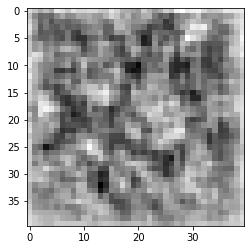

In [7]:
from keras.utils.vis_utils import plot_model

generator = make_generator_model()
plot_model(generator, to_file='gen_plot.png', show_shapes=True, show_layer_names=True)
generator.summary()
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [8]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(40,40,1)))
    #model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    #model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same'))
    #model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    #model.add(layers.Dropout(0.5))

    model.add(layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    #model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    #model.add(layers.Dropout(0.5))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    model.add(layers.Activation(activation='sigmoid'))
    return model

In [9]:
discriminator = make_discriminator_model()
discriminator.summary()
plot_model(discriminator, to_file='disc_plot.png', show_shapes=True, show_layer_names=True)
decision = discriminator(generated_image)
print (decision)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 20, 20, 64)        1664      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 20, 20, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 128)       73856     
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 20, 20, 128)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 10, 10, 256)       295168    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 10, 10, 256)       0         
                                                                 
 flatten (Flatten)           (None, 25600)            

In [10]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

In [11]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = 0.5 * (real_loss + fake_loss)
    return total_loss

In [12]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [13]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [15]:
config = 1
transform = "layering"
preprocess = "scale-1to1"
imsize = "40"
gen_path_name = f"{'/content/drive/Shareddrives/Senior Thesis/Models/gen_'}{config}{'_'}{preprocess}{'_'}{transform}{'_'}{imsize}{'.hdf5'}"
disc_path_name = f"{'/content/drive/Shareddrives/Senior Thesis/Models/disc_'}{config}{'_'}{preprocess}{'_'}{transform}{'_'}{imsize}{'.hdf5'}"

In [16]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
#seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed_train = tf.random.normal([BATCH_SIZE, noise_dim])
seed = seed_train[0:num_examples_to_generate,:]

In [34]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
#@tf.function
def train_step(image_batch):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(image_batch, training=True)
      fake_output = discriminator(generated_images, training=True)
      
      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)
      
      gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
      gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
      
      generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
      discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [19]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
# minimum input shape is (75,75,3)
FIDinput = (80, 80, 3)
# 2400 feature maps
FIDmodel = InceptionV3(include_top=False, weights='imagenet', pooling='avg', input_shape=FIDinput)

def calculate_fid(model, real_images, fake_images):
  #real_images = preprocess_input(real_images)
  #fake_images = preprocess_input(fake_images)
  act1 = model.predict(real_images)
  act2 = model.predict(fake_images)
  # calculate mean and covariance statistics
  mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
  mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
	# calculate sum squared difference between means
  ssdiff = np.sum((mu1 - mu2)**2.0)
	# calculate sqrt of product between cov
  covmean = scipy.linalg.sqrtm(sigma1.dot(sigma2))
	# check and correct imaginary numbers from sqrt
  if np.iscomplexobj(covmean):
    covmean = covmean.real
	# calculate score
  fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
  return fid

In [22]:
def train(dataset, epochs, p, augment):

  FIDs = []

  for epoch in range(epochs):
    start = time.time()
    image_batch_tot = np.zeros((BATCH_SIZE, 40, 40, 1))

    for image_batch in dataset:
      # if augment:
      #   image_batch = image_batch.numpy()
      #   for i in range(len(image_batch)):
      #     im = image_batch[i]
      #     p = np.random.binomial(1,p)
      #     if p==1:
      #       x = np.random.uniform(0,1,1)
      #       if x<0.25: #shear
      #         val_x = float(np.random.uniform(0,0.2,1))
      #         val_y = float(np.random.uniform(0,0.2,1))
      #         transf = ((1, val_x, 0, val_y, 1, 0, 0, 0))
      #         im = tfa.image.transform(im, transf, fill_value = 0.6)
      #         #cv2_imshow(np.array(im))
      #       elif x>0.25 and x<0.5: #rotation
      #         angle = np.random.uniform(0,2*math.pi,1)
      #         im = tfa.image.rotate(im, angle, fill_value = 0.6)
      #         #cv2_imshow(np.array(im))
      #       elif x>0.5 and x<0.75: #crop and resize
      #         box = np.random.uniform(0.7,0.9,1)
      #         height, width, _ = im.shape
      #         im = im[0:int(box*height), 0:int(box*width),:]
      #         im = tf.image.resize(im, (height,width))
      #         #cv2_imshow(np.array(im))
      #       else: #brightening
      #         delta = np.random.uniform(-0.7,0.7,1)
      #         im = tf.image.adjust_brightness(im, delta)
      #       image_batch[i] = im
      #     image_batch = tf.convert_to_tensor(image_batch)

      train_step(image_batch)
      image_batch_tot = np.array(list(image_batch))

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch + 1,seed)

    # Save the model every 15 epochs
    if epoch == epochs-1:
      print("saved models")
      generator.save(gen_path_name)
      discriminator.save(disc_path_name)

    gen_images = generator(seed_train, training=False)
    # Calculate FID Score for the output set
    real = np.zeros((BATCH_SIZE,80,80,1))
    fake = np.zeros((BATCH_SIZE,80,80,1))
    
    gen_images = gen_images.numpy()
    
    for i in range(image_batch_tot.shape[0]):
      im_real = cv2.resize(image_batch_tot[i,:,:,:],(80,80))
      im_fake = cv2.resize(gen_images[i,:,:,:],(80,80))
      real[i,:,:,:] = im_real[:,:,np.newaxis]
      fake[i,:,:,:] = im_fake[:,:,np.newaxis]

    real = np.repeat(real, 3, axis = 3)
    fake = np.repeat(fake, 3, axis = 3) 
    fid = calculate_fid(FIDmodel, real, fake)
    FIDs.append(fid)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    print ('FID: ', fid)

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator, epochs, seed)

  return FIDs

In [23]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(8, 8))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

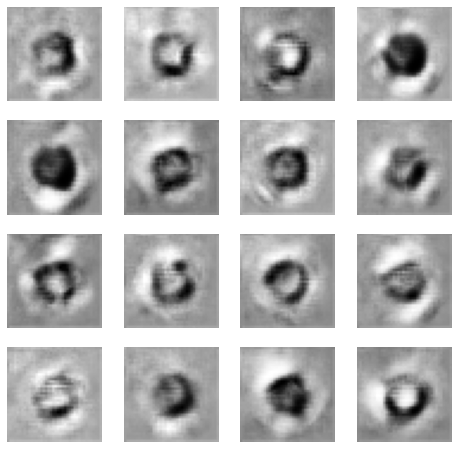

In [24]:
#train_dataset = tf.data.Dataset.from_tensor_slices(train_images_scaled).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
FID = train(train_dataset, 10, 0.8, False)

1432.420147359404


ValueError: ignored

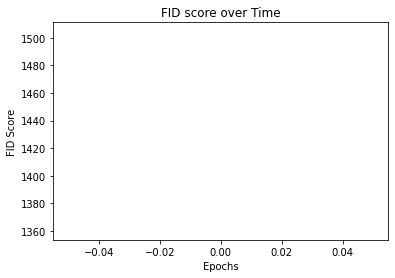

In [26]:
print(FID[0])

#FID = np.array(FID)
plt.plot(FID[0])
plt.ylabel('FID Score')
plt.xlabel('Epochs')
plt.title('FID score over Time')

import pandas as pd
data = np.zeros(EPOCHS)
data = FID[0]
df = pd.DataFrame(data)
df.to_excel(excel_writer = "/content/data.xlsx")

Restore the latest checkpoint.

In [27]:
gen_old = tf.keras.models.load_model(gen_path_name)
disc_old = tf.keras.models.load_model(disc_path_name)
gen_old.compile()
disc_old.compile()

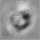

In [28]:
noise = tf.random.normal([1, 100])
generated_images = gen_old(noise, training=False)
generated_images = np.array(generated_images) * 127.5 + 127.5 #shift back values
# for i in range((len(generated_images))):
#   im_path = f"{'/content/drive/Shareddrives/Senior Thesis/GAN_Images/'}{i}{'.jpg'}"
#   im = np.float32(generated_images[i])
#   cv2.imwrite(im_path, im)
cv2_imshow(np.array(generated_images)[0,:,:,:])

In [29]:
# for layer in gen_old.layers: 
#   layer.trainable = False
#   print('Layer ' + layer.name + ' frozen.')
# # We take the last layer of our the model and add it to our classifier
last = gen_old.layers[-1].output
x = tf.keras.layers.Flatten()(last)
x = tf.keras.layers.Dense(6400, activation='relu', name='fc1')(x)
x = tf.keras.layers.Reshape((80,80,1))(x)
x = tf.keras.layers.Activation('tanh')(x)

generator = tf.keras.Model(gen_old.input, x)
generator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_input (InputLayer)    [(None, 100)]             0         
                                                                 
 dense (Dense)               (None, 12800)             1280000   
                                                                 
 reshape (Reshape)           (None, 10, 10, 128)       0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 20, 20, 128)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 20, 20, 64)        131136    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 20, 20, 64)        0         
                                                             

In [30]:
# for layer in disc_old.layers: 
#   layer.trainable = False
#   #print('Layer ' + layer.name + ' frozen.')
# # We take the first layer of our the model and make that the output of our classifier

discriminator = Sequential()
discriminator.add(tf.keras.layers.Conv2D(64,(3,3), strides=(1,1), activation='relu',padding='same',input_shape = (80,80,1)))
discriminator.add(tf.keras.layers.Conv2D(1, (3,3), strides=(2,2), activation='relu',padding='same'))
discriminator.add(disc_old)

discriminator.summary()
disc_old.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_102 (Conv2D)         (None, 80, 80, 64)        640       
                                                                 
 conv2d_103 (Conv2D)         (None, 40, 40, 1)         577       
                                                                 
 sequential_1 (Sequential)   (None, 1)                 396289    
                                                                 
Total params: 397,506
Trainable params: 397,506
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 20, 20, 64)        1664      
                                                                 
 leaky_re_lu_4 (LeakyReLU)

In [31]:
faulty_dir = '/content/drive/Shareddrives/Senior Thesis/Casting_image/casting_data/casting_data/images/def_front/'
ok_dir = '/content/drive/Shareddrives/Senior Thesis/Casting_image/casting_data/casting_data/images/ok_front/'
directories = (faulty_dir, ok_dir)

# check the total number of images we have
faulty = 0
ok = 0
j = -1
for direct in directories:
  j += 1
  print(direct)
  for file in os.listdir(direct):
    # count only number of faulty images
    if j == 0:
      faulty += 1
    if j == 1:
      ok += 1

print(faulty, ok)
# set the values of the X and y arrays
num_images = faulty
input_shape = (80, 80, 1)
height = input_shape[0]
width = input_shape[1]
channels = input_shape[2]

X = np.zeros((num_images,height,width,channels))

# populate the arrays
i = 0
for file in os.listdir(faulty_dir):
  path = (faulty_dir+file)
  im = plt.imread(path)
  scaled_im = cv2.resize(im[:,:,0],(height,width))
  scaled_im = scaled_im[:, :, np.newaxis]
  X[i,:,:,:] = scaled_im
  # 1 for faulty
  i+=1

train_images = X;

/content/drive/Shareddrives/Senior Thesis/Casting_image/casting_data/casting_data/images/def_front/
/content/drive/Shareddrives/Senior Thesis/Casting_image/casting_data/casting_data/images/ok_front/
4184 3157


In [32]:
train_images_scaled = train_images.astype('float32')
train_images_scaled = (train_images_scaled - 127.5) / 127.5  # Normalize the images to [-1, 1]
print(type(train_images_scaled), train_images_scaled.shape)
print(np.min(train_images), np.max(train_images))
print(np.min(train_images_scaled), np.max(train_images_scaled))

<class 'numpy.ndarray'> (4184, 80, 80, 1)
0.0 255.0
-1.0 1.0


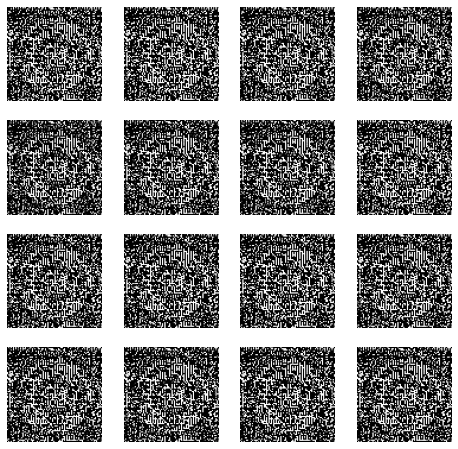

KeyboardInterrupt: ignored

In [35]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images_scaled).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
FID = train(train_dataset, 100, 1, False)